# Modeling and Simulation in Python

Chapter 22

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

Lab Author @ Joseph Simone

In [71]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import pandas as pd

### Vectors

A `Vector` object represents a vector quantity.  In the context of mechanics, vector quantities include position, velocity, acceleration, and force, all of which might be in 2D or 3D.

You can define a `Vector` object without units, but if it represents a physical quantity, you will often want to attach units to it.

I'll start by grabbing the units we'll need.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Here's a two dimensional `Vector` in meters.

In [3]:
A = Vector(3, 4) * m

array([3., 4.]) <Unit('meter')>

We can access the elements by name.

In [4]:
A.x

3.0 <Unit('meter')>

In [5]:
A.y

4.0 <Unit('meter')>

The magnitude is the length of the vector.

In [6]:
A.mag

5.0 <Unit('meter')>

The angle is the number of radians between the vector and the positive x axis.

In [7]:
A.angle

0.9272952180016122 <Unit('radian')>

If we make another `Vector` with the same units,

In [8]:
B = Vector(1, 2) * m

array([1., 2.]) <Unit('meter')>

We can add `Vector` objects like this

In [9]:
A + B

array([4., 6.]) <Unit('meter')>

And subtract like this:

In [10]:
A - B

array([2., 2.]) <Unit('meter')>

We can compute the Euclidean distance between two Vectors.

In [11]:
A.dist(B)

2.8284271247461903 <Unit('meter')>

And the difference in angle

In [12]:
A.diff_angle(B)

-0.17985349979247822 <Unit('radian')>

If we are given the magnitude and angle of a vector, what we have is the representation of the vector in polar coordinates.

In [13]:
mag = A.mag
angle = A.angle

0.9272952180016122 <Unit('radian')>

We can use `pol2cart` to convert from polar to Cartesian coordinates, and then use the Cartesian coordinates to make a `Vector` object.

In this example, the `Vector` we get should have the same components as `A`.

In [14]:
x, y = pol2cart(angle, mag)
Vector(x, y)

array([3., 4.]) <Unit('meter')>

Another way to represent the direction of `A` is a unit vector, which is a vector with magnitude 1 that points in the same direction as `A`.  You can compute a unit vector by dividing a vector by its magnitude:

In [15]:
A / A.mag

array([0.6, 0.8]) <Unit('dimensionless')>

Or by using the `hat` function, so named because unit vectors are conventionally decorated with a hat, like this: $\hat{A}$:

In [16]:
A.hat()

array([0.6, 0.8]) <Unit('dimensionless')>

**Exercise:** Create a `Vector` named `a_grav` that represents acceleration due to gravity, with x component 0 and y component $-9.8$ meters / second$^2$.

In [17]:
a_grav = Vector(0, -9.8) * m / s**2

array([ 0. , -9.8]) <Unit('meter / second ** 2')>

### Degrees and radians

Pint provides units to represent degree and radians.

In [18]:
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

If you have an angle in degrees,

In [19]:
angle = 45 * degree
angle

45 <Unit('degree')>

You can convert to radians.

In [20]:
angle_rad = angle.to(radian)

0.7853981633974483 <Unit('radian')>

If it's already in radians, `to` does the right thing.

In [21]:
angle_rad.to(radian)

0.7853981633974483 <Unit('radian')>

You can also convert from radians to degrees.

In [22]:
angle_rad.to(degree)

45.0 <Unit('degree')>

As an alterative, you can use `np.deg2rad`, which works with Pint quantities, but it also works with simple numbers and NumPy arrays:

In [23]:
np.deg2rad(angle)

0.7853981633974483 <Unit('radian')>

**Exercise:** Create a `Vector` named `a_force` that represents acceleration due to a force of 0.5 Newton applied to an object with mass 0.3 kilograms, in a direction 45 degrees up from the positive x-axis.

Add `a_force` to `a_grav` from the previous exercise.  If that addition succeeds, that means that the units are compatible.  Confirm that the total acceleration seems to make sense.

In [79]:
N = UNITS.newton
m = 0.5 * N
angle = 45 * degree
theta = angle.to(radian)
x, y = pol2cart(theta, m)
force = Vector(x, y)

mass = 0.3 * kg
a_force = force / mass
a_force




array([1.1785113, 1.1785113]) <Unit('newton / kilogram')>

In [80]:
a_force + a_grav

array([ 1.1785113, -8.6214887]) <Unit('newton / kilogram')>

In [29]:
# Solution goes here

### Baseball

Here's a `Params` object that contains parameters for the flight of a baseball.

In [30]:
t_end = 10 * s
dt = t_end / 100

params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.33,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end=t_end, dt=dt)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.33
angle,45 degree
velocity,40.0 meter / second
t_end,10 second


And here's the function that uses the `Params` object to make a `System` object.

In [31]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    angle, velocity = params.angle, params.velocity
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    R = Vector(params.x, params.y)
    V = Vector(vx, vy)
    init = State(R=R, V=V)
    
    # compute area from diameter
    diameter = params.diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

Here's how we use it:

In [32]:
system = make_system(params)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.33
angle,45 degree
velocity,40.0 meter / second
t_end,10 second


Here's a function that computes drag force using vectors:

In [33]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `v`.
    
    V: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * V.mag**2 * C_d * area / 2
    direction = -V.hat()
    f_drag = direction * mag
    return f_drag

We can test it like this.

In [34]:
V_test = Vector(10, 10) * m/s
drag_force(V_test, system)

array([-0.11719681, -0.11719681]) <Unit('kilogram * meter / second ** 2')>

Here's the slope function that computes acceleration due to gravity and drag.

In [35]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    R, V = state
    mass, g = system.mass, system.g
    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    A = a_grav + a_drag
    
    return V, A

Always test the slope function with the initial conditions.

In [36]:
slope_func(system.init, 0, system)

(array([28.28427125, 28.28427125]) <Unit('meter / second')>,
 array([ -6.46603088, -16.26603088]) <Unit('meter / second ** 2')>)

We can use an event function to stop the simulation when the ball hits the ground:

In [37]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    R, V = state
    return R.y

In [38]:
event_func(system.init, 0, system)

1.0 <Unit('meter')>

Now we can call `run_ode_solver`

In [39]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


The final label tells us the flight time.

In [40]:
flight_time = get_last_label(results) * s

5.004505488017051 <Unit('second')>

The final value of `x` tells us the how far the ball landed from home plate:

In [41]:
R_final = get_last_value(results.R)
x_dist = R_final.x

99.30497406350605 <Unit('meter')>

### Visualizing the results

The simplest way to visualize the results is to plot x and y as functions of time.

Saving figure to file figs/chap22-fig01.pdf


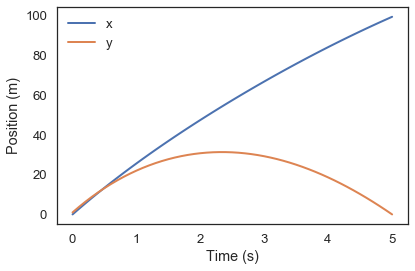

In [42]:
xs = results.R.extract('x')
ys = results.R.extract('y')

xs.plot()
ys.plot()

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

savefig('figs/chap22-fig01.pdf')

We can plot the velocities the same way.

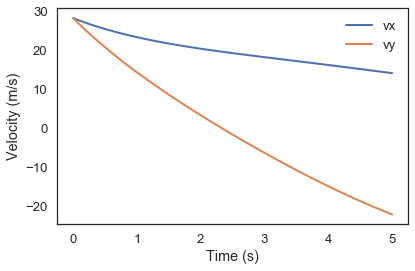

In [43]:
vx = results.V.extract('x')
vy = results.V.extract('y')

vx.plot(label='vx')
vy.plot(label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

The x velocity slows down due to drag.

The y velocity drops quickly while drag and gravity are in the same direction, then more slowly after the ball starts to fall.

Another way to visualize the results is to plot y versus x.  The result is the trajectory of the ball through its plane of motion.

Saving figure to file figs/chap22-fig02.pdf


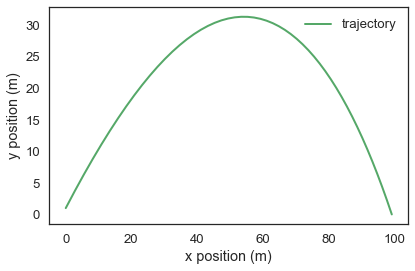

In [44]:
def plot_trajectory(results):
    xs = results.R.extract('x')
    ys = results.R.extract('y')
    plot(xs, ys, color='C2', label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)
savefig('figs/chap22-fig02.pdf')

### Animation

One of the best ways to visualize the results of a physical model is animation.  If there are problems with the model, animation can make them apparent.

The ModSimPy library provides `animate`, which takes as parameters a `TimeSeries` and a draw function.



The draw function should take as parameters a `State` object and the time.  It should draw a single frame of the animation.

Inside the draw function, you almost always have to call `set_xlim` and `set_ylim`.  Otherwise `matplotlib` auto-scales the axes, which is usually not what you want.

In [47]:
xs = results.R.extract('x')
ys = results.R.extract('y')

def draw_func(state, t):
   # set_xlim(xs)
   # set_ylim(ys)
    x, y = state.R
    plot(x, y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

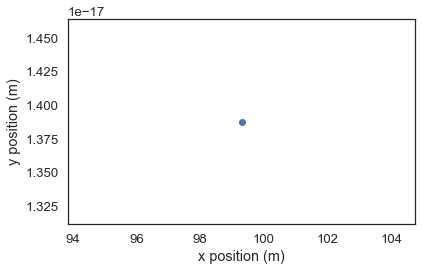

In [48]:
animate(results, draw_func)

**Exercise:** Delete the lines that set the x and y axes (or [comment them out](https://en.wiktionary.org/wiki/comment_out)) and see what the animation does.

### Under the hood

`Vector` is a function that returns a `ModSimVector` object.

In [49]:
V = Vector(3, 4)
type(V)

modsim.modsim.ModSimVector

A `ModSimVector` is a specialized kind of Pint `Quantity`.

In [50]:
isinstance(V, Quantity)

True

There's one gotcha you might run into with Vectors and Quantities.  If you multiply a `ModSimVector` and a `Quantity`, you get a `ModSimVector`:

In [51]:
V1 = V * m

array([3., 4.]) <Unit('meter')>

In [52]:
type(V1)

modsim.modsim.ModSimVector

But if you multiply a `Quantity` and a `Vector`, you get a `Quantity`:

In [53]:
V2 = m * V

array([3., 4.]) <Unit('meter')>

In [54]:
type(V2)

pint.quantity.build_quantity_class.<locals>.Quantity

With a `ModSimVector` you can get the coordinates using dot notation, as well as `mag`, `mag2`, and `angle`:

In [55]:
V1.x, V1.y, V1.mag, V1.angle

(3.0 <Unit('meter')>,
 4.0 <Unit('meter')>,
 5.0 <Unit('meter')>,
 0.9272952180016122 <Unit('radian')>)

With a `Quantity`, you can't.  But you can use indexing to get the coordinates:

In [56]:
V2[0], V2[1]

(3.0 <Unit('meter')>, 4.0 <Unit('meter')>)

And you can use vector functions to get the magnitude and angle.

In [57]:
vector_mag(V2), vector_angle(V2)

(5.0 <Unit('meter')>, 0.9272952180016122 <Unit('radian')>)

And often you can avoid the whole issue by doing the multiplication with the `ModSimVector` on the left.

### Exercises

**Exercise:** Run the simulation with and without air resistance.  How wrong would we be if we ignored drag?

In [58]:
# Hint

system_no_drag = System(system, C_d=0)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0
angle,45 degree
velocity,40.0 meter / second
t_end,10 second


In [81]:
results_without_drag, details = run_ode_solver(system_no_drag, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


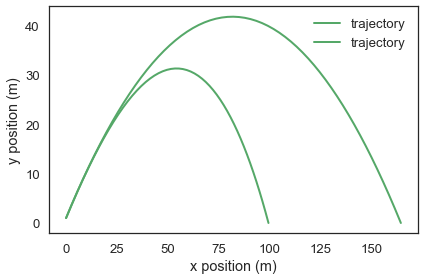

In [82]:
plot_trajectory(results)
plot_trajectory(results_without_drag)

In [63]:
ball_distance = get_last_value(results.R).x

99.30497406350605 <Unit('meter')>

In [64]:
ball_distance_no_drag = get_last_value(results_no_drag.R).x

164.25596844639247 <Unit('meter')>

In [65]:
ball_distance - ball_distance_no_drag

-64.95099438288642 <Unit('meter')>

**Exercise:** The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / meter$^3$.  How much farther would a ball hit with the same velocity and launch angle travel?

In [66]:
# Hint

system2 = System(system, rho=1.0*kg/m**3)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.0 kilogram / meter ** 3
C_d,0.33
angle,45 degree
velocity,40.0 meter / second
t_end,10 second


In [83]:
second_result, second_details = run_ode_solver(system2, slope_func, events=event_func)
x = second_result.R.extract('x')
ball_distance2 = get_last_value(x)

105.77787365390016 <Unit('meter')>

In [84]:
ball_distance2 - ball_distance

6.472899590394107 <Unit('meter')>

**Exercise:** The model so far is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does.  The following figure, from Adair, [*The Physics of Baseball*](https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC), shows coefficient of drag as a function of velocity.

<img src="data/baseball_drag.png" width="400">


I used [an online graph digitizer](https://automeris.io/WebPlotDigitizer/) to extract the data and save it in a CSV file.  Here's how we can read it:

Modify the model to include the dependence of `C_d` on velocity, and see how much it affects the results.  Hint: use `interpolate`.

In [ ]:
baseball_drag = pd.read_csv('data/baseball_drag.csv')
mph = Quantity(baseball_drag['Velocity in mph'], UNITS.mph)
mps = mph.to(m/s)
baseball_drag.index = magnitude(mps)
baseball_drag.index.name = 'Velocity in meters per second'
baseball_drag

In [62]:
# Solution goes here

In [63]:
# Solution goes here

In [64]:
C_d = drag_interp(43 * m / s)

In [65]:
# Solution goes here

In [66]:
# Solution goes here

In [67]:
# Solution goes here

In [68]:
# Solution goes here

In [69]:
# Solution goes here

In [70]:
# Solution goes here

In [71]:
# Solution goes here

In [72]:
# Solution goes here